In [ ]:
#loading essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from torch.utils.data import random_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#connected with error during compiling model
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_md

2024-01-04 20:14:59.191736: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 20:14:59.191878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 20:14:59.225272: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 20:15:03.560484: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 9.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
#data exploration
data = pd.read_csv('/content/drive/MyDrive/ZUM/projekt/data2.csv')

In [ ]:
data.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [ ]:
data.shape

(5791, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [ ]:
#column names normalization
data.rename(columns={'Text':'text', 'Sentiment':'target'}, inplace=True)

In [ ]:
data.groupby('target').nunique()

,text
target,
-1,2106
1,3685


In [ ]:
#changing text to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())

In [ ]:
#remove urls,
re_url = re.compile(r'((www.[^\s]+)|(http?://[^\s]+))')
data['text'] = data['text'].apply(lambda x: re_url.sub('', x))

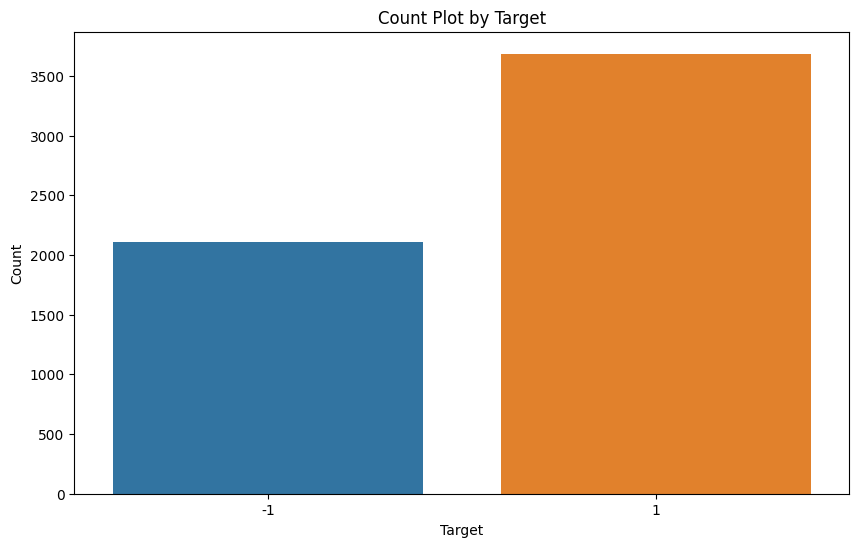

In [ ]:
# Perform the groupby and nunique operations
grouped_data = data.groupby('target').nunique()

# Reset the index to make 'target' a regular column
grouped_data = grouped_data.reset_index()

# Create a count plot using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.countplot(x='target', data=data)

# Add labels and title
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Count Plot by Target')

# Show the plot
plt.show()

Experiment with data symbols like $


In [ ]:
#remove all characters except alphabet letters, whitespace characters, apostrophe.
#I leave the numbers and the dollar sign because I will analyze tweets related to the markets
re_letter_number_and_dollar = re.compile(r"[^a-zA-Z\d\s'$]")
data['text'] = data['text'].apply(lambda x: re_letter_number_and_dollar.sub('', x))
data.sample(5)

,text,target
3204,yhoo trying to break hod,1
6,aap user if so then the current downtrend wil...,-1
5205,investors hope thursdays opec meeting will sig...,1
3111,aeg 30 min o and 1 overlaid 20 ema cruising hi...,1
2145,deck lets squeeze 40 short,1


In [ ]:
#replacing all number with word "number"
re_number_with_word = re.compile(r'\b\d+\b')
data['text'] = data['text'].apply(lambda x: re_number_with_word.sub('number', x))
data.sample(5)

,text,target
2536,swy added to long,1
4562,notable s in oil gas equipment svs stocks oi...,1
1906,aap begin to ollover i,-1
1257,keep ostk on your watchlist breaking out from...,1
5242,applications for participation in the feds com...,1


In [ ]:
data['text'].iloc[3691]

'bac number by close even better'

In [ ]:
#checking nan values
data[data['text'].isna()]

,text,target


In [ ]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_md

2024-01-04 20:15:39.234625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 20:15:39.234712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 20:15:39.236540: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 20:15:41.592023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.7.1/en_core_web_md-3.7.1-py3-none-any.whl (42.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_m

In [ ]:
#loading spacy
nlp = spacy.load('en_core_web_md')
nlp.add_pipe('sentencizer')

In [ ]:
#removing stopwords
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['text'] = data['text'].apply(remove_stopwords)
data.sample(5)

,text,target
1239,nfx stopping stop number goes number near futu...,1
4303,look number candles jpm thing coiled tight it'...,1
39,aap obbers hit apple store paris prefer merche...,1
5119,havent seen markets reflect extent damage coro...,-1
2985,there's reason znga largest lobbyist online ga...,1


In [ ]:
#lematization of text
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

data['text'] = data['text'].progress_apply(lemmatize)
data.sample(5)

100%|██████████| 5791/5791 [01:08<00:00, 84.03it/s] 


,text,target
2326,dish break watch number,1
5646,coronavirus crisis global stock surge investor...,1
1735,esi watch list low number line volume number d...,1
3109,user tjx stop loss number beat number,1
2170,legged goog number sergey arry be not sell sha...,1


In [ ]:
#change sentiment values to 1 and 0
data['target'].replace(-1, 0, inplace=True)

In [ ]:
#checking nan values
data[data['text'].isna()]

,text,target


In [ ]:
data['text'].iloc[3691]

'bac number close well'

In [ ]:
#importing clean data to new csv file for another models
data.to_csv('data2_clean.csv', index=False)

In [ ]:
#importing clean datawithout headers to new csv file for another models
data.to_csv('data2_clean_without_headers.csv', index=False, header=False)

# Tokenization

In [ ]:
import pandas as pd
from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torchdata.datapipes as dp
import torch
import torch.nn as nn
import torch.optim as optim
import time
!pip install -U portalocker>=2.0.0

In [ ]:
fpath = '/content/drive/MyDrive/ZUM/projekt/data2_clean.csv'
data_pipe = dp.iter.IterableWrapper([fpath])
data_pipe = dp.iter.FileOpener(data_pipe, mode='rb')
data_pipe = data_pipe.parse_csv(skip_lines=0, delimiter=',', as_tuple=True)

In [ ]:
df = pd.read_csv(fpath, usecols=['text', 'target'])

In [ ]:
df.columns

Index(['text', 'target'], dtype='object')

In [ ]:
df.head(20)

,text,target
0,kicker watchlist xide tit soq pnk cpw bpz aj t...,1
1,user aap movie number return feageed indicator...,1
2,user I have afraid short amzn looking like nea...,1
3,mnta number,1
4,oi number,1
5,pgnx number,1
6,aap user current downtrend break shortterm cor...,0
7,monday 's relative weakness nyx win tie tap ic...,0
8,goog ower trend line channel test volume support,1
9,aap watch tomorrow ong entry,1


In [ ]:
for sample in data_pipe:
  print(sample)
  break

('text', 'target')


In [ ]:
import random
data_list = list(data_pipe)
random.shuffle(data_list)

split_ratio = 0.8
train_size = int(split_ratio * len(data_list))
train_data = data_list[:train_size]
test_data = data_list[train_size:]

train_iter = iter(train_data)
test_iter = iter(test_data)

In [ ]:
tokenizer = get_tokenizer('spacy', 'en_core_web_md')

In [ ]:
def yield_tokens(data_iter):
  for text, _ in data_iter:
      yield tokenizer(text)


In [ ]:
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
#checking variable
vocab(['I', 'raise'])

[54, 263]

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == '1' else 0

In [ ]:
text_pipeline('It will raise')

[0, 190, 263]

In [ ]:
def collate_batch(batch):
    text_list, label_list, lengths = [], [], []
    for ( _text, _label) in batch:
        processed_text = torch.tensor(text_pipeline(_text))
        if processed_text.size(0) > 0:
          label_list.append(label_pipeline(_label))
          text_list.append(processed_text)
          lengths.append(processed_text.size(0))
    if len(lengths) == 0:
        return None, None, None

    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    text_list = pad_sequence(text_list, batch_first=True)
    return text_list.long(), label_list, lengths

In [ ]:
data_list = list(data_pipe)
random.shuffle(data_list)

split_ratio = 0.8
train_size = int(split_ratio * len(data_list))
train_data = data_list[:train_size]
test_data = data_list[train_size:]

train_iter = iter(train_data)
test_iter = iter(test_data)

In [ ]:
train_dataset = list(train_iter)
test_dataset = list(test_iter)

validation_ratio = 0.5
n_test = len(test_dataset)
n_val = int(n_test*validation_ratio)
n_test = n_test-n_val

val_dataset, test_dataset = random_split(test_dataset, [n_val, n_test])

In [ ]:
BATCH_SIZE = 64
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
        return self.fc(hidden.squeeze(0))

In [ ]:
input_dim = len(vocab)
embedding_dim = 100
hidden_dim = 128
output_dim = 1 #for binary classification

model = LSTM(input_dim, embedding_dim, hidden_dim, output_dim)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Model has {count_parameters(model):,} parameters')

Model ma 859,089 parametrów


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
criterion = nn.BCEWithLogitsLoss() #for binary classification

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y): #for binary classification
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


In [ ]:
def train(model, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in dataloader:
      #label_list, text_list, lenghts
      texts, labels, lengths = batch
      texts, labels = texts.to(device), labels.to(device, dtype=torch.float64)
      optimizer.zero_grad()

      predictions = model(texts, lengths).squeeze(1)
      loss = criterion(predictions, labels)
      acc = binary_accuracy(predictions, labels)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
      for batch in dataloader:
        texts, labels, lengths = batch
        texts, labels = texts.to(device), labels.to(device, dtype=torch.float64)

        predictions = model(texts, lengths).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#connected with error ocurrs during training. There was a problem with values out of bound, i tried to find place where it occurs
for (labels, texts, lengths) in train_dataloader:
    print(f"Labels: {labels}, Texts: {texts}, Lengths: {lengths}")

Labels: tensor([[   4,  308,   62,  ...,    0,    0,    0],
        [ 537,  713, 6369,  ...,    0,    0,    0],
        [ 308,   99,  652,  ...,    0,    0,    0],
        ...,
        [1488, 1396,   89,  ...,    0,    0,    0],
        [ 122,    1, 1206,  ...,    0,    0,    0],
        [ 700,  160,    1,  ...,    0,    0,    0]]), Texts: tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]), Lengths: tensor([ 6,  8, 13,  5,  7,  5, 15, 11, 12,  6,  6, 15,  3,  4, 13,  3, 10,  9,
        10,  4,  8, 11,  8,  4, 17,  4, 15,  7,  9,  8,  7, 10,  9,  5,  7,  9,
         9, 16,  5, 16,  5, 13, 14, 17,  8,  7, 16,  5, 12, 13,  9, 10,  3, 15,
        23, 15, 12,  9,  8, 10,  4, 13,  7,  7])
Labels: tensor([[ 578,  780,  816,  ...,    0,    0,    0],
        [ 598,    1, 1539,  ...,    0,    0,    0],
        [  63,   78,   39,  ..

In [ ]:
#connected with error during training. There is a problem with values out of bound, i tried to find place where it occurs
for batch in train_dataloader:
    _, _, lengths = batch
    print(lengths)

tensor([ 8, 12,  2,  9, 10, 11,  3,  6, 10,  3,  2, 10,  2, 10,  7,  4,  7,  6,
        14,  4,  6,  6,  8, 10, 12,  7,  9,  5,  3,  5,  8,  3,  5,  6, 12,  5,
         9,  2,  3,  5, 12, 12, 12,  3, 16, 10,  5,  6,  9, 21, 15,  9,  9,  3,
        12, 11,  7, 18,  5, 12,  3, 11,  6,  6])
tensor([11,  3, 20,  5,  9,  3,  3,  3,  6,  6, 14,  8,  4,  6,  6,  5,  2,  3,
         9, 10, 18,  5,  3,  9,  6, 14, 17,  5,  5, 16,  7,  8, 11, 13, 17,  4,
         7,  4,  7, 14, 14,  9, 12,  3,  6, 11, 16,  8,  8,  4, 14, 10,  7, 13,
        12, 20,  7, 17,  5,  5,  9,  8, 10, 12])
tensor([ 6,  2, 13,  1,  9, 10, 12,  4,  5, 21, 11, 14, 12, 13, 12, 12, 13, 11,
         4,  6,  7,  9, 11, 16, 11, 10,  4, 14,  4,  4,  5, 11, 10, 13,  9,  7,
         5,  3, 18,  3,  8,  7, 16, 15, 12,  9,  9, 13, 11, 14,  7, 12, 11,  8,
         9,  5, 13, 10,  8, 11, 13, 24, 10, 13])
tensor([ 2,  4,  5,  3,  3,  5, 11, 13, 10,  7,  4, 14,  4, 11, 10, 17, 10,  9,
         7,  8,  6, 11,  9, 11, 13,  8, 16, 11,  3,  

In [ ]:
N_EPOCHS = 50
best_valid_loss = float('inf') #positive infinity

for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)

  end_time = time.time()

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'lstm_model2.pt')

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')


Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 0.694 | Train Acc: 49.95%
	 Val. Loss: 0.697 | Val. Acc: 50.76%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.692 | Train Acc: 51.86%
	 Val. Loss: 0.694 | Val. Acc: 48.21%
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.691 | Train Acc: 53.21%
	 Val. Loss: 0.692 | Val. Acc: 49.93%
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.689 | Train Acc: 54.81%
	 Val. Loss: 0.690 | Val. Acc: 52.28%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.687 | Train Acc: 56.11%
	 Val. Loss: 0.688 | Val. Acc: 53.53%
Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.686 | Train Acc: 57.03%
	 Val. Loss: 0.686 | Val. Acc: 55.56%
Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.684 | Train Acc: 58.28%
	 Val. Loss: 0.684 | Val. Acc: 56.50%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.683 | Train Acc: 59.50%
	 Val. Loss: 0.682 | Val. Acc: 57.13%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.682 | Train Acc: 60.00%
	 Val. Loss: 0.680 | Val. Acc: 57.91%
Epoch: 10 | Epoch Time: 0m 2s
	Train 

In [ ]:
test_loss, test_acc = evaluate(model, test_dataloader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.660 | Test Acc: 63.75%


In [ ]:
def predict_sentiment_lstm(model, tokenizer, vocab, sentence, device):
    model.eval()
    # Tokenize the sentence
    tokens = tokenizer(sentence)
    # Convert tokens to vocabulary indices
    vocab_tokens = vocab(tokens)
    # Create a tensor with indices
    tensor = torch.LongTensor(vocab_tokens).unsqueeze(0).to(device)
    # Get the lengths of sequences
    lengths = torch.tensor([len(vocab_tokens)]).to(device)
    with torch.no_grad():
      # Call the model with both the tensor and lengths
      output = model(tensor, lengths)
    _, predicted_class = torch.max(output, 1)
    return predicted_class.item()

#Example
sentence_to_classify = 'Stocks goes down'
predicted_class = predict_sentiment_lstm(model, tokenizer, vocab, sentence_to_classify, device)
print(predicted_class)


0


In [ ]:
sentence_to_classify = 'bot synm number bot peix number'
predicted_class = predict_sentiment_lstm(model, tokenizer, vocab, sentence_to_classify, device)
print(predicted_class)

0


Conclusion:
Based on the results of the prediction on the test set, it can be said that the model in this form works best. There were experiments conducted, on the data provided. Various variants were tested, e.g. removing all special characters, numbers, lemmatization. But the best results were achieved by the model with changed numbers to a single word "number", with lemmatization.